In [1]:
%load_ext autoreload
%autoreload 2
import json
import dgl
from sklearn.metrics import f1_score
import torch as th
import dgl.nn.pytorch as dglnn
import torch.nn as nn
from dgl.dataloading import GraphDataLoader
import torch.nn.functional as F
import networkx as nx
import warnings
from feature_extraction.base_featurizer import BaseFeaturizer
import torch
from graph_construction.tps_graph import create_dummy_dgl_graph, tps_graph
import numpy as np

from dgl_classifier.trainer import GraphDataset,snap_pred, tps_to_dgl, get_clasification_vec,\
tps_graph_const, extract_data, runner


import warnings

from preprocessing.utils import load_BGPS_from_json
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

In [2]:
path = '/work/data/data_files/all_data.json'
data = json.load(open(path,'r'))

In [3]:
len(data)

3316

In [4]:
from preprocessing.utils_script import relative_error_v2
#function consider pred, actual runtimes
data_filt = []
data_timeout = []
for i in data:
    try:
        i['speedup'] = relative_error_v2(i['bloom_runtime'],i['jena_runtime'])
        data_filt.append(i)
    except TypeError:
        data_timeout.append(i)
del data
data = data_filt
del data_filt

In [5]:
len(data),len(data_timeout)

(1537, 1779)

In [6]:
speedup = [x['speedup']*100 for x in data if x['speedup'] > 0]

In [7]:
def print_stat(lst):
    print("Mean ", np.mean(lst))
    print("STD ", np.std(lst))
    print("Min ", np.min(lst))
    print("25% ", np.quantile(lst,q=0.25))
    print("50% ", np.quantile(lst,q=0.5))
    print("75% ", np.quantile(lst,q=0.75))
    print("Max ", np.max(lst))

In [8]:
import matplotlib.pyplot as plt

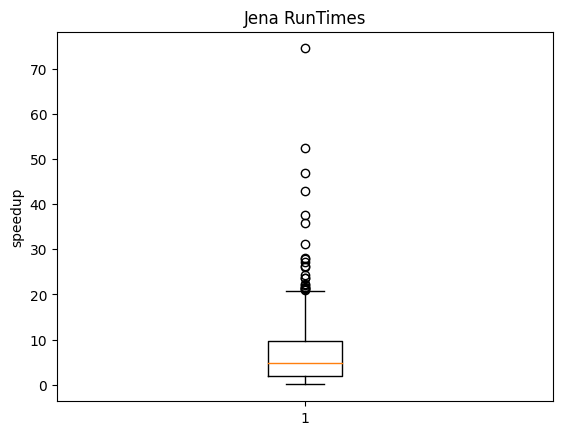

<Figure size 640x480 with 0 Axes>

In [9]:
#plt.figure(figsize=(3,6))
plt.ylabel('speedup')
plt.title('Jena RunTimes')
plt.boxplot(speedup)
plt.show()
plt.clf()

In [10]:
print_stat(speedup)

Mean  7.057220694162157
STD  7.642237299277555
Min  0.08169414844601076
25%  2.065228578555907
50%  4.874480871178017
75%  9.59468446656652
Max  74.43859551545917


In [11]:
len(speedup)

457

In [12]:
def query_gen_speedup(speedup, dur_diff):
    for i in data:
        i['speedup'] = relative_error_v2(i['bloom_runtime'],i['jena_runtime'])*100
        i['dur_diff'] = (i['jena_runtime'] - i['bloom_runtime']) *1e-6 #difference in ms
        if i['speedup'] > speedup and i['dur_diff'] >= dur_diff:
            yield i

In [13]:
gen = query_gen_speedup(5, 1)

In [16]:
query = next(gen)
query

{'query': 'SELECT (COUNT(*) AS ?count) WHERE { <http://www.wikidata.org/entity/Q22803914> ?p ?x2 . ?x2 <http://www.wikidata.org/prop/direct/P264> ?x3 . ?x3 <http://www.wikidata.org/prop/direct/P750> ?x4 } LIMIT 10000',
 'bloom_runtime': 947926044,
 'jena_runtime': 1018656015,
 'leapfrog': 25854905,
 'path': '/leapfrog-rdf-benchmark/results/modified_bgps/MP3',
 'speedup': 6.943459809639468,
 'dur_diff': 70.72997099999999}

In [17]:
pred_freq = json.load(open('/work/data/extracted_statistics/pred_freq.json','r'))

In [18]:
preds = list(pred_freq.keys())
freqs = list(pred_freq.values())

In [19]:
def sort_lists(list1, list2):
    zipped_pairs = zip(list2, list1)
    z = [x for _, x in sorted(zipped_pairs, reverse=True)]
    list2.sort(reverse=True)
    return z, list2
preds,freqs =  sort_lists(preds, freqs)

In [22]:
i=200
query_preds = []
for i in range(200,250):
    print(preds[i], f"{freqs[i]:,}")
    query_preds.append(preds[i])

http://www.wikidata.org/prop/direct/P793 423,349
http://www.wikidata.org/prop/direct/P497 422,583
http://www.wikidata.org/prop/direct/P2163 416,898
http://www.wikidata.org/prop/direct-normalized/P2163 416,898
http://www.wikidata.org/prop/direct/P691 413,963
http://www.wikidata.org/prop/direct/P6224 413,701
http://www.wikidata.org/prop/direct/P1132 412,666
http://www.wikidata.org/prop/direct/P613 406,153
http://www.wikidata.org/prop/direct/P1216 399,822
http://www.wikidata.org/prop/direct/P413 396,919
http://www.wikidata.org/prop/direct/P1070 396,638
http://www.wikidata.org/prop/direct/P819 391,011
http://www.wikidata.org/prop/direct/P159 390,194
http://www.wikidata.org/prop/direct/P140 377,097
http://www.wikidata.org/prop/direct/P710 372,914
http://www.wikidata.org/prop/direct/P3373 365,568
http://www.wikidata.org/prop/direct/P463 362,037
http://www.wikidata.org/prop/direct/P3098 352,526
http://www.wikidata.org/prop/direct/P818 346,841
http://www.wikidata.org/prop/direct/P8363 345,482


In [138]:
def query_gen(preds):
    s = f"""SELECT ?p (COUNT(*) AS ?count) WHERE {{ ?x1 ?p ?x2 .
             ?x2 <http://www.wikidata.org/prop/direct/P640> ?x3 .
            }} GROUPBY ?p 
            LIMIT 10 """
    print(s)
query_gen(1)

SELECT ?p (COUNT(*) AS ?count) WHERE { ?x1 ?p ?x2 .
             ?x2 <http://www.wikidata.org/prop/direct/P640> ?x3 .
            } GROUPBY ?p 
            LIMIT 10 


In [139]:
!pip install sparqlwrapper

In [152]:
from SPARQLWrapper import SPARQLWrapper, JSON
class QueryGenerator:
    def __init__(self, url):
        self.sparql = SPARQLWrapper( url )
        self.sparql.setReturnFormat(JSON)

    def query(self, query):
        self.sparql.setQuery(query)
        try:
            ret = self.sparql.queryAndConvert()
            return ret
        except Exception as e:
            print(e)
    def get_other_pred(self, pred):
        q = f"""
            SELECT ?p (COUNT(*) AS ?count) WHERE {{ 
            ?x1 ?p ?x2 .
             ?x2 {'<'+pred+'>'} ?x3 .
            }} GROUPBY ?p 
            LIMIT 10
        """
        return self.query(q)
queryier = QueryGenerator('http://172.21.233.23:83/wikidata/sparql')
#r = queryier.query('select * where { ?s ?p ?o} LIMIT 1')
r = queryier.get_other_pred('http://www.wikidata.org/prop/direct/P793')
print(r)

{'head': {'vars': ['p', 'count']}, 'results': {'bindings': [{'p': {'type': 'uri', 'value': 'http://www.wikidata.org/prop/direct/P8289'}, 'count': {'type': 'literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'value': '255'}}, {'p': {'type': 'uri', 'value': 'http://www.wikidata.org/prop/direct/P8047'}, 'count': {'type': 'literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'value': '458521'}}, {'p': {'type': 'uri', 'value': 'http://www.wikidata.org/prop/direct/P2515'}, 'count': {'type': 'literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'value': '39'}}, {'p': {'type': 'uri', 'value': 'http://www.wikidata.org/prop/direct/P1080'}, 'count': {'type': 'literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'value': '48'}}, {'p': {'type': 'uri', 'value': 'http://www.wikidata.org/prop/direct/P4900'}, 'count': {'type': 'literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'value': '1'}}, {'p': {'type': 'uri', 'value': 'http://ww

In [ ]:
from SPARQLWrapper import SPARQLWrapper, JSON

def generate_cyclic_sparql_queries(predicates, endpoint_url):
    sparql = SPARQLWrapper(endpoint_url)
    sparql.setReturnFormat(JSON)

    # Generate cyclic SPARQL queries with 3 triple patterns
    queries = []
    for p in predicates:
        connected_preds = []
        sparql.setQuery(f"""
            SELECT DISTINCT ?p WHERE {{
                ?s <{p}> ?o .
                ?o ?p ?o1 .
            }} LIMIT 100
        """)
        results = sparql.query().convert()
        for result in results['results']['bindings']:
            connected_preds.append(result['p']['value'])
        for p1 in connected_preds:
            sparql.setQuery(f"""
                SELECT (COUNT(*) AS ?count) WHERE {{
                    ?x1 <{p1}> ?x .
                }}
            """)
            results = sparql.query().convert()
            count1 = int(results['results']['bindings'][0]['count']['value'])
            if count1 > 1000:
                connected_preds2 = []
                sparql.setQuery(f"""
                    SELECT DISTINCT ?p WHERE {{
                        ?s <{p1}> ?o .
                        ?o ?p ?o1 .
                    }} LIMIT 100
                """)
                results = sparql.query().convert()
                for result in results['results']['bindings']:
                    connected_preds2.append(result['p']['value'])
                

                for p2 in connected_preds2:
                    sparql.setQuery(f"""
                        SELECT (COUNT(*) AS ?count) WHERE {{
                            ?x1 <{p2}> ?x .
                        }}
                    """)
                    results = sparql.query().convert()
                    count2 = int(results['results']['bindings'][0]['count']['value'])
                    if count2 > 1000:
                        queries.append(f"""
                        SELECT (COUNT(*) AS ?count) WHERE {{
                            ?x1 <{p}> ?x .
                            x?  {p1} ?x2 .
                            ?x2 {p2} ?x1 .
                        }}LIMIT 10000
                        """)
                        print(f"""
                        SELECT (COUNT(*) AS ?count) WHERE {{
                            ?x1 <{p}> ?x .
                            x?  {p1} ?x2 .
                            ?x2 {p2} ?x1 .
                        }}LIMIT 10000
                        """)
    return queries
new_queries = generate_cyclic_sparql_queries(query_preds, 'http://172.21.233.23:83/wikidata/sparql')

Observations is that the BF triple pattern (the one with only bounded variable, we make an illogical triple pattern (this would require a lot of existence checks that return negative)
For queries with 3 triple patterns.

In [ ]:
from SPARQLWrapper import SPARQLWrapper, JSON

def check_queries

def generate_cyclic_sparql_queries_3tp(predicates, endpoint_url):
    sparql = SPARQLWrapper(endpoint_url)
    sparql.setReturnFormat(JSON)

    # Generate cyclic SPARQL queries with 3 triple patterns
    queries = []
    for p in predicates:
        connected_preds = []
        sparql.setQuery(f"""
            SELECT DISTINCT ?p WHERE {{
                ?s <{p}> ?o .
                ?o ?p ?o1 .
            }} LIMIT 100
        """)
        results = sparql.query().convert()
        for result in results['results']['bindings']:
            connected_preds.append(result['p']['value'])
        for p1 in connected_preds:
            sparql.setQuery(f"""
                SELECT (COUNT(*) AS ?count) WHERE {{
                    ?x1 <{p1}> ?x .
                }}
            """)
            results = sparql.query().convert()
            count1 = int(results['results']['bindings'][0]['count']['value'])
            if count1 > 1000:
                connected_preds2 = []
                sparql.setQuery(f"""
                    SELECT DISTINCT ?p WHERE {{
                        ?s <{p1}> ?o .
                        ?o ?p ?o1 .
                    }} LIMIT 100
                """)
                results = sparql.query().convert()
                for result in results['results']['bindings']:
                    connected_preds2.append(result['p']['value'])
                

                for p2 in connected_preds2:
                    sparql.setQuery(f"""
                        SELECT (COUNT(*) AS ?count) WHERE {{
                            ?x1 <{p2}> ?x .
                        }}
                    """)
                    results = sparql.query().convert()
                    count2 = int(results['results']['bindings'][0]['count']['value'])
                    if count2 > 1000:
                        queries.append(f"""
                        SELECT (COUNT(*) AS ?count) WHERE {{
                            ?x1 <{p}> ?x .
                            x?  {p1} ?x2 .
                            ?x2 {p2} ?x1 .
                        }}LIMIT 10000
                        """)
                        print(f"""
                        SELECT (COUNT(*) AS ?count) WHERE {{
                            ?x1 <{p}> ?x .
                            x?  {p1} ?x2 .
                            ?x2 {p2} ?x1 .
                        }}LIMIT 10000
                        """)
    return queries
new_queries = generate_cyclic_sparql_queries(query_preds, 'http://172.21.233.23:83/wikidata/sparql')
json.dump(new_queries, open('/work/new_queries.json'))